In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
from samples.pallet import pallet

In [5]:
config = pallet.PalletConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/pallet")

In [6]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset_train = pallet.PalletDataset()
dataset_train.load_pallet(BALLOON_DIR, "train")

# Must call before using the dataset
dataset_train.prepare()


dataset_val = pallet.PalletDataset()
dataset_val.load_pallet(BALLOON_DIR, "train")

# Must call before using the dataset
dataset_val.prepare()

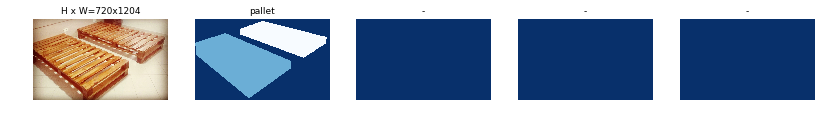

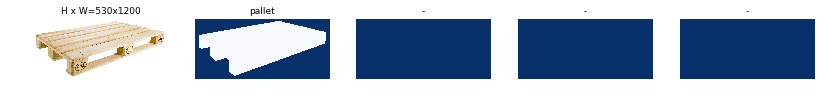

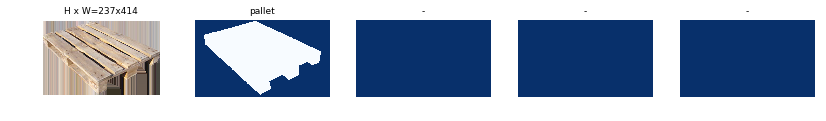

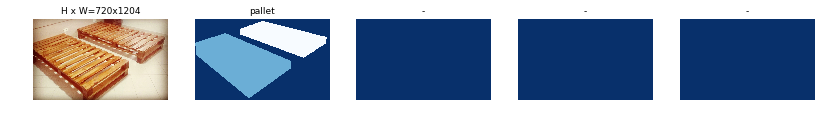

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\pallet_back\Segmentation\Mask_RCNN-master\logs\balloon20181130T1331\mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
100/100 [==============================] - 7661s 77s/step - loss: 1.0118 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1593 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.4455 - val_loss: 0.5269 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.1317 - val_mrcnn_class_loss: 0.0223 - val_mrcnn_bbox_loss: 0.2277 - val_mrcnn_mask_loss: 0.1423
Epoch 2/5
100/100 [==============================] - 7466s 75s/step - loss: 0.3765 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1405 - val_loss: 0.2779 - val_rpn_class_loss: 0.0028 - val_rpn_bbox_loss: 0.0766 - val_mrcnn_class_loss: 0.0133 - val_mrcnn_bbox_loss: 0.0710 - val_mrcnn_mask_loss: 0.1141
Epoch 3/5
100/100 [==============================] - 7436s 74s/step - loss: 0.2634 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1126 - val_loss: 0.2214 - val_rpn_clas

In [11]:
#pulei
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 5. LR=0.0001

Checkpoint Path: D:\pallet_back\Segmentation\Mask_RCNN-master\logs\balloon20181130T1331\mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 6/10
100/100 [==============================] - 11299s 113s/step - loss: 0.1229 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0706 - val_loss: 0.1160 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.0075 - val_mrcnn_class_loss: 0.0136 - val_mrcnn_bbox_loss: 0.0215 - val_mrcnn_mask_loss: 0.0719
Epoch 7/10
100/100 [==============================] - 11240s 112s/step - loss: 0.1020 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0638 - val_loss: 0.0908 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.0045 - val_mrcnn_class_loss: 0.0130 - val_mrcnn_bbox_loss: 0.0142 - val_mrcnn_mask_loss: 0.0576
Epoch 8/10
100/100 [==============================] - 11244s 112s/step - loss: 0.0938 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0604 - val_loss: 0.0893 - val

In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "pallet_modelos/mask_rcnn_pallets_1_epoca.h5")
model.keras_model.save_weights(model_path)